In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [17]:
# mean and std of all MNIST images
mean_gray = 0.1307
std_gray = 0.3081

# transform the images to tensors
# normalize a tensor image with mean and standard deviation
# for n channels, this transform will normalize each channel of the input torch.Tensor
# input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((mean_gray), (std_gray))])
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((mean_gray), (std_gray))])

# composes a set of transformations to apply to the dataset
# input[channel] = (input[channel] - mean[channel]) / std[channel]
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray), (std_gray))])

train_dataset = datasets.MNIST(root = "./temp",
                              train = True,
                              transform = transforms,
                              download = True)

test_dataset = datasets.MNIST(root = "./temp",
                              train = False,
                              transform = transforms)


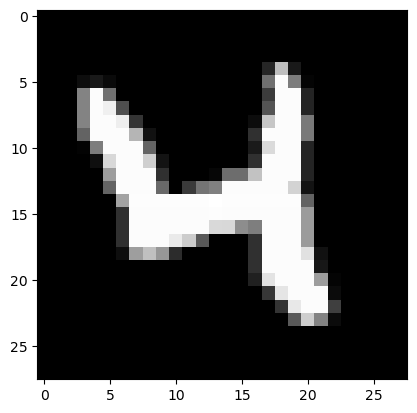

In [18]:
# visualize the data 

import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * std_gray + mean_gray
plt.imshow(random_img.reshape(28,28), cmap = "gray")

In [19]:
print(train_dataset[20][1])

4


In [20]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False)

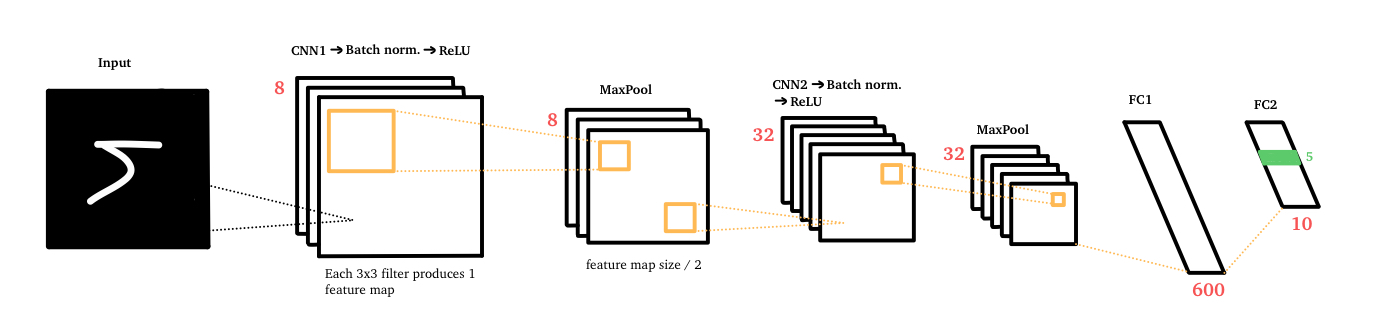

In [21]:
class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # same padding: input_size = output_size
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        # flatten the 32 feature maps: 7*7*32 = 1568
        self.fc1 = nn.Linear(in_features = 1568, out_features = 600)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(in_features = 600, out_features = 10)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        # flatten the 32 feauture maps from max pooling to feed to FC1
        # it will take the shape (batch_size, 1568) = (100, 1568)
        
        # print("Size of out before reshaping:", out.size())
        out = out.view(out.size(0), -1)  # Flatten the tensor to have 100 samples and calculate the other dimension automatically
        # print("Size of out after reshaping:", out.size()) 
        
        # forward through fully-connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
        

In [22]:
# create an object of the CNN class
model = CNN()

CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [23]:
# training the CNN

epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    # dropout and batch normalization behave differently during training and testing
    # it's important to clarigy when we're training and testing
    model.train()
    
    for i, (inputs, labels) in enumerate (train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # this will call the CNN class, and since it has a parameter, it'll run the forward prop function
        outputs = model(inputs)
        
        # calculate and save the loss
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item() # loss.item() extracts the loss from the tensor
        
        # clear the gradient
        optimizer.zero_grad()
        
        # backprop
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # calculate the accuracy
        _, predicted = torch.max(outputs, 1) # takes the maximum of the outputs across the first dimension (we want the second value, the index)
        correct += (predicted == labels).sum().item() # total number of correct predictions
        iterations += 1
    
    train_loss.append(iter_loss / iterations) # iteration loss for all epochs divided by the number of iterations (600 b/c 600 batches) = training loss for 1 epoch
    train_accuracy.append(correct / len(train_dataset)) # correct predictions for all images / total number of images
        
    
    # testing phase
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    
    for i, (inputs, labels) in enumerate (test_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item() 

        
        # calculate the accuracy
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum().item() 
        iterations += 1
    
    test_loss.append(iter_loss / iterations) 
    test_accuracy.append(correct / len(test_dataset)) 
    
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Training Loss: {train_loss[-1]:.3f}, "
          f"Training Accuracy: {train_accuracy[-1]:.3f}, "
          f"Testing Loss: {test_loss[-1]:.3f}, "
          f"Testing Accuracy: {test_accuracy[-1]:.3f}")


    

Epoch 1/10, Training Loss: 0.637, Training Accuracy: 0.825, Testing Loss: 0.067, Testing Accuracy: 0.980
Epoch 2/10, Training Loss: 0.173, Training Accuracy: 0.949, Testing Loss: 0.042, Testing Accuracy: 0.987
Epoch 3/10, Training Loss: 0.121, Training Accuracy: 0.965, Testing Loss: 0.046, Testing Accuracy: 0.988
Epoch 4/10, Training Loss: 0.097, Training Accuracy: 0.972, Testing Loss: 0.034, Testing Accuracy: 0.990
Epoch 5/10, Training Loss: 0.082, Training Accuracy: 0.976, Testing Loss: 0.038, Testing Accuracy: 0.990
Epoch 6/10, Training Loss: 0.077, Training Accuracy: 0.978, Testing Loss: 0.036, Testing Accuracy: 0.989
Epoch 7/10, Training Loss: 0.070, Training Accuracy: 0.980, Testing Loss: 0.046, Testing Accuracy: 0.985
Epoch 8/10, Training Loss: 0.064, Training Accuracy: 0.982, Testing Loss: 0.035, Testing Accuracy: 0.991
Epoch 9/10, Training Loss: 0.066, Training Accuracy: 0.982, Testing Loss: 0.039, Testing Accuracy: 0.989
Epoch 10/10, Training Loss: 0.061, Training Accuracy: 0

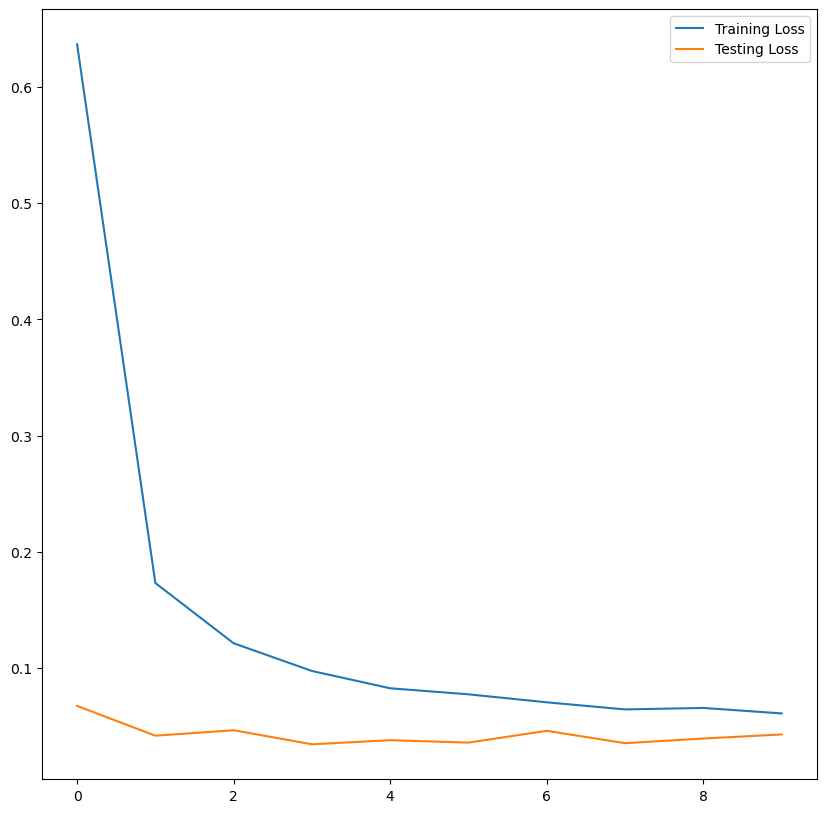

In [24]:
# plotting the loss

f = plt.figure(figsize = (10,10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()
plt.show()

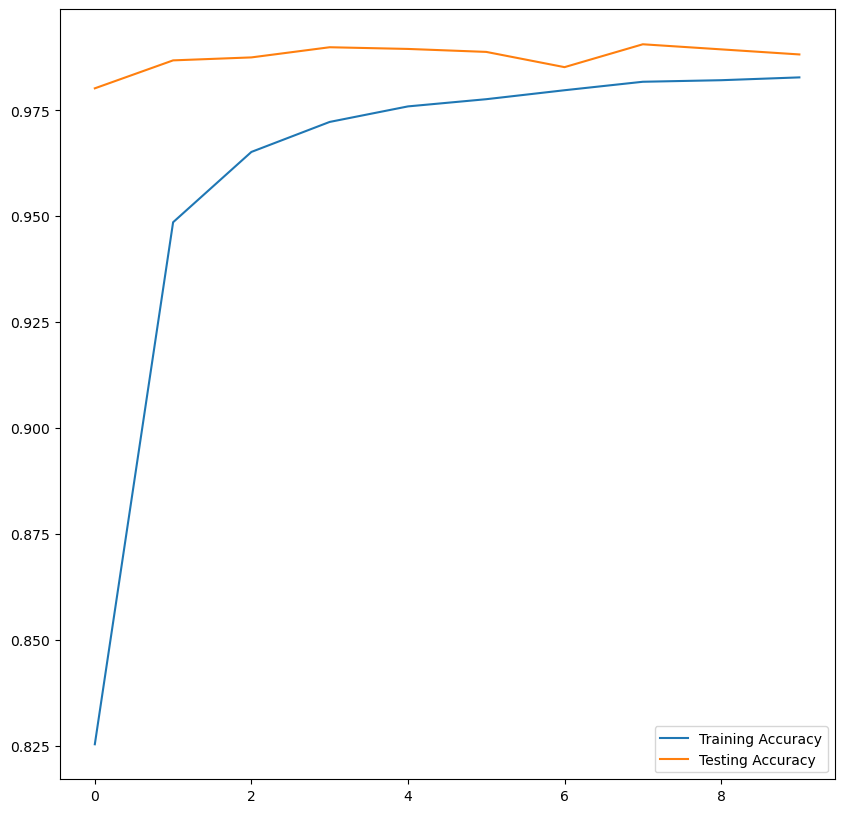

In [25]:
# plotting the accuracy

f = plt.figure(figsize = (10,10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()

In [26]:
def predict(img_name, model):
    image = cv2.imread(img_name, 0) # read the image in grayscale
    ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) # applies a binary threshold. Pixels > 127 --> 255 (white), pixels ≤ 127 --> 0 (black)
    img = 255 - thresholded # inverts the image
    cv2.imshow("Original", img) # displays the image and waits for a keystroke to close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img) # coverts to a PIL image (neccessary to use 'transforms')
    img = transforms_photo(img) # applies transformations from 'transforms_photo'
    img = img.view(1,1,28,28) # reshapes tensor (batch_size, channels, height, width). CNN input tensors need to be 4d
    
    model.eval()
    
    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()
    
    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output, 1)
    
    return predicted.item()